In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

In [ ]:
n = 1000
g = 2000
k = 50
X = np.dot(np.random.randn(n, k).astype(np.float32), np.random.randn(g, k).astype(np.float32).T)

hyper_params = RandomParams(eta_low=0.001, eta_high=0.01, lamb1_low=0.001, lamb1_high=0.01, lamb2_low=0.04, lamb2_high=0.01, num_reps=10)

errorsDF, trainErrorDF, testErrorDF = CrossValidation(X, k, hyper_params, foldcount=5, returnVectorDF=True)

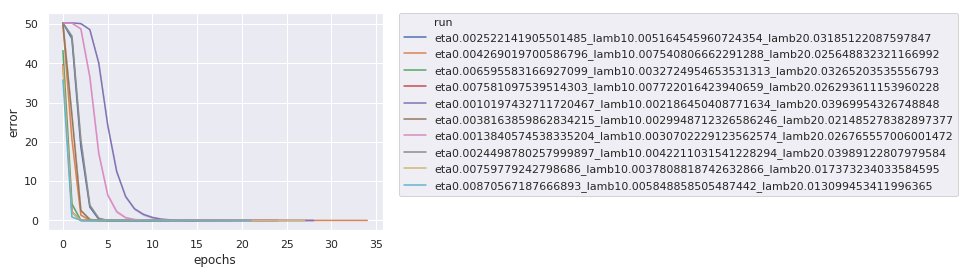

In [6]:
PlotErrorDF(trainErrorDF)

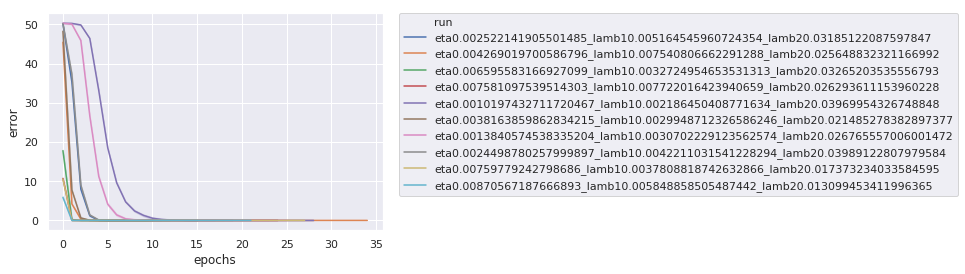

In [7]:
PlotErrorDF(testErrorDF)

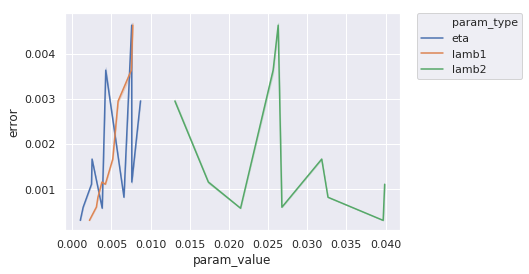

In [8]:
PlotParamDF(errorsDF)

In [76]:
def GenerateSimulatedData(n = 10, g = 200, p=1):
   
    X = np.zeros((n, g + p))
    X[:, g] = np.random.uniform(low=-1.0, high=1.0, size=(n,))
    
    correlations = np.clip(np.random.randn(g,) * 0.2, -1.0, 1.0)
    correlations = correlations[np.argsort(np.abs(correlations))[::-1]]
    
    for i in range(g):
        X[:, i] = correlations[i] * X[:, g] + np.sqrt(1 - np.square(correlations[i])) * np.random.randn(n)
    return X, correlations

In [135]:
n = 3
g = 5
p = 1 #number of phenotypes
k = 2
    
numReps = 1

intersectionGap = 10
numPlotPoints = int(g / intersectionGap)
intersectionMatrix = np.zeros((numReps, numPlotPoints))

#for rep in range(numReps):
    
#Generate data here
neighbors = {}
X, correlations = GenerateSimulatedData(n, g, p)

#Find optimal eta, lamb1, lamb2
eta = 0.005
lamb1 = 0.02
lamb2 = 0.001

#Train on all of the data
U_pred, V_pred = CreateLatentVariables(n, g+p, k)
U_pred, V_pred = FactorizeMatrix(X, U_pred, V_pred, neighbors, eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=600)

topRankedGenes = GetTopGenes(V_pred, g, np.arange(0, g))

obs_corr = [pearsonr(X[:, i].T, X[:, g])[0] for i in range(g)]
obs_corr_order = np.argsort(obs_corr)[::-1]

print(correlations)
print(obs_corr)
print(obs_corr_order)
print(topRankedGenes)
print(X)
print(np.dot(U_pred, V_pred.T))

[ 0.77989509 -0.55753279  0.4982213  -0.1139337   0.09699672]
[0.444513060236283, -0.9294842605970921, 0.8766938641400671, 0.4486256619212523, 0.729865485269056]
[2 4 3 0 1]
[4 2 0 3 1]
[[-0.09920789 -1.1424741  -0.21645089 -1.07858318  1.36316786  0.35465344]
 [ 0.6349201  -1.94421532  0.9496811   0.48925612 -0.15183872  0.57827756]
 [ 0.08939093 -0.44747934 -0.85995723 -0.68254382 -1.46078017 -0.55725275]]
[[ 0.11636603 -0.89923966  0.50632757 -0.05089974  1.0410738   0.5201735 ]
 [ 0.4839842  -1.9713945   0.51888716 -0.07769933  0.03157991  0.46413946]
 [ 0.20542794 -0.2302824  -0.32394084  0.01296905 -1.4605157  -0.38569823]]


In [ ]:
currentNumIntersected = 0

for i in range(0, g, intersectionGap):
    currentGeneSlice = topRankedGenes[i:i+intersectionGap]
    additiveIntersection = np.sum(np.in1d(currentGeneSlice, genesDrivingPhenotype))

    currentNumIntersected += additiveIntersection

    intersectionMatrix[rep, i] = currentNumIntersected
        

In [ ]:
intersectionIndices = np.arange(0, g, intersectionGap) #(numPlotPoints,)
df = pd.DataFrame(intersectionMatrix.T)
df['x'] = intersectionIndices
df = pd.melt(df, id_vars=['x'])
sns.lineplot(x='x', y='value', data=df, ci='sd')